In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import mne


In [2]:
# We'll set the log-level to 'WARNING' so the output is less verbose.
mne.set_log_level('WARNING')

In [3]:
# Let's explore one of the edf files.
raw = mne.io.read_raw_edf('Char/aashay_A.edf')

In [4]:
# Explore metadata included in the file
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: COUNTER, INTERPOLATED, AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, ...
 chs: 39 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2017-02-25 20:29:24 UTC
 nchan: 39
 projs: []
 sfreq: 128.0 Hz
>

In [5]:
# Display all channels available in this EEG.
channels = raw.ch_names
print(f'There are {len(channels)} channels in this EEG file:\n')
print(channels)

There are 39 channels in this EEG file:

['COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'RAW_CQ', 'GYROX', 'GYROY', 'MARKER', 'SYNC', 'TIME_STAMP_s', 'TIME_STAMP_ms', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_CMS', 'CQ_DRL']


In [6]:
# Transform this raw data in array information
data = raw.get_data().T
print(f'Data shape: {data.shape}')
print(f'Data size: {data.size}')
print('Channels Values:\n')
print(data)

Data shape: (1536, 39)
Data size: 59904
Channels Values:

[[5.40000000e-05 0.00000000e+00 4.22410256e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.50000000e-05 0.00000000e+00 4.22974359e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.60000000e-05 0.00000000e+00 4.23384615e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.90000000e-05 0.00000000e+00 4.15282051e-03 ... 0.00000000e+00
  4.00000000e-06 4.00000000e-06]
 [4.00000000e-05 0.00000000e+00 4.16871795e-03 ... 0.00000000e+00
  4.00000000e-06 4.00000000e-06]
 [4.10000000e-05 0.00000000e+00 4.14564103e-03 ... 0.00000000e+00
  4.00000000e-06 4.00000000e-06]]


In [7]:
# Save as DF for further exploration:
df_data = pd.DataFrame(data, columns=channels)

In [8]:
# Lets take a Peek at our dataset
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   COUNTER        1536 non-null   float64
 1   INTERPOLATED   1536 non-null   float64
 2   AF3            1536 non-null   float64
 3   F7             1536 non-null   float64
 4   F3             1536 non-null   float64
 5   FC5            1536 non-null   float64
 6   T7             1536 non-null   float64
 7   P7             1536 non-null   float64
 8   O1             1536 non-null   float64
 9   O2             1536 non-null   float64
 10  P8             1536 non-null   float64
 11  T8             1536 non-null   float64
 12  FC6            1536 non-null   float64
 13  F4             1536 non-null   float64
 14  F8             1536 non-null   float64
 15  AF4            1536 non-null   float64
 16  RAW_CQ         1536 non-null   float64
 17  GYROX          1536 non-null   float64
 18  GYROY   

In [9]:
df_data.head().style

,COUNTER,INTERPOLATED,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,RAW_CQ,GYROX,GYROY,MARKER,SYNC,TIME_STAMP_s,TIME_STAMP_ms,CQ_AF3,CQ_F7,CQ_F3,CQ_FC5,CQ_T7,CQ_P7,CQ_O1,CQ_O2,CQ_P8,CQ_T8,CQ_FC6,CQ_F4,CQ_F8,CQ_AF4,CQ_CMS,CQ_DRL
0,0.000054,0.000000,0.004224,0.004228,0.004226,0.004227,0.004222,0.004225,0.004213,0.004223,0.004214,0.004233,0.004229,0.004246,0.004232,0.004222,0.000000,0.002047,0.002042,0.000000,0.000000,0.001202,0.000569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000055,0.000000,0.004230,0.004224,0.004231,0.004231,0.004244,0.004236,0.004223,0.004226,0.004223,0.004235,0.004225,0.004248,0.004232,0.004221,0.000000,0.002048,0.002041,0.000000,0.000000,0.001202,0.000576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000056,0.000000,0.004234,0.004231,0.004233,0.004231,0.004226,0.004221,0.004231,0.004227,0.004219,0.004234,0.004224,0.004246,0.004230,0.004223,0.000000,0.002048,0.002043,0.000000,0.000000,0.001202,0.000585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000057,0.000000,0.004231,0.004229,0.004230,0.004229,0.004224,0.004225,0.004231,0.004217,0.004215,0.004232,0.004217,0.004246,0.004223,0.004221,0.000000,0.002047,0.002042,0.000000,0.000000,0.001202,0.000593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000058,0.000000,0.004227,0.004218,0.004225,0.004229,0.004238,0.004236,0.004225,0.004212,0.004217,0.004233,0.004217,0.004246,0.004223,0.004216,0.000000,0.002047,0.002041,0.000000,0.000000,0.001202,0.000600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
df_data.describe().style

,COUNTER,INTERPOLATED,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,RAW_CQ,GYROX,GYROY,MARKER,SYNC,TIME_STAMP_s,TIME_STAMP_ms,CQ_AF3,CQ_F7,CQ_F3,CQ_FC5,CQ_T7,CQ_P7,CQ_O1,CQ_O2,CQ_P8,CQ_T8,CQ_FC6,CQ_F4,CQ_F8,CQ_AF4,CQ_CMS,CQ_DRL
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000
mean,0.000064,0.000000,0.004231,0.004233,0.004232,0.004232,0.004231,0.004228,0.004231,0.004231,0.004232,0.004233,0.004232,0.004227,0.004231,0.004232,0.000396,0.002046,0.002042,0.000000,0.000000,0.001208,0.000500,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
std,0.000037,0.000000,0.000175,0.000174,0.000173,0.000160,0.000009,0.000027,0.000189,0.000193,0.000930,0.000003,0.000169,0.000016,0.000169,0.000157,0.000415,0.000003,0.000003,0.000000,0.000000,0.000004,0.000288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.003453,0.003453,0.003450,0.003849,0.004199,0.004130,0.003389,0.003358,0.000615,0.004222,0.003450,0.004163,0.003500,0.003483,0.000000,0.002036,0.002022,0.000000,0.000000,0.001202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000032,0.000000,0.004207,0.004209,0.004215,0.004213,0.004224,0.004218,0.004211,0.004215,0.004203,0.004231,0.004214,0.004222,0.004208,0.004215,0.000000,0.002044,0.002040,0.000000,0.000000,0.001205,0.000253,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
50%,0.000064,0.000000,0.004225,0.004226,0.004229,0.004238,0.004232,0.004232,0.004227,0.004230,0.004227,0.004233,0.004227,0.004226,0.004224,0.004229,0.000000,0.002046,0.002042,0.000000,0.000000,0.001208,0.000504,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
75%,0.000096,0.000000,0.004249,0.004257,0.004252,0.004253,0.004238,0.004242,0.004247,0.004251,0.004261,0.004234,0.004247,0.004236,0.004246,0.004248,0.000840,0.002047,0.002043,0.000000,0.000000,0.001211,0.000747,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
max,0.000128,0.000000,0.004917,0.004881,0.004820,0.005029,0.004254,0.004351,0.004925,0.004817,0.007707,0.004243,0.004832,0.004254,0.004802,0.004944,0.001007,0.002061,0.002049,0.000000,0.000000,0.001214,0.001000,0.000004,0.000004,0.000004,0.000004,0.000000,0.000001,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004


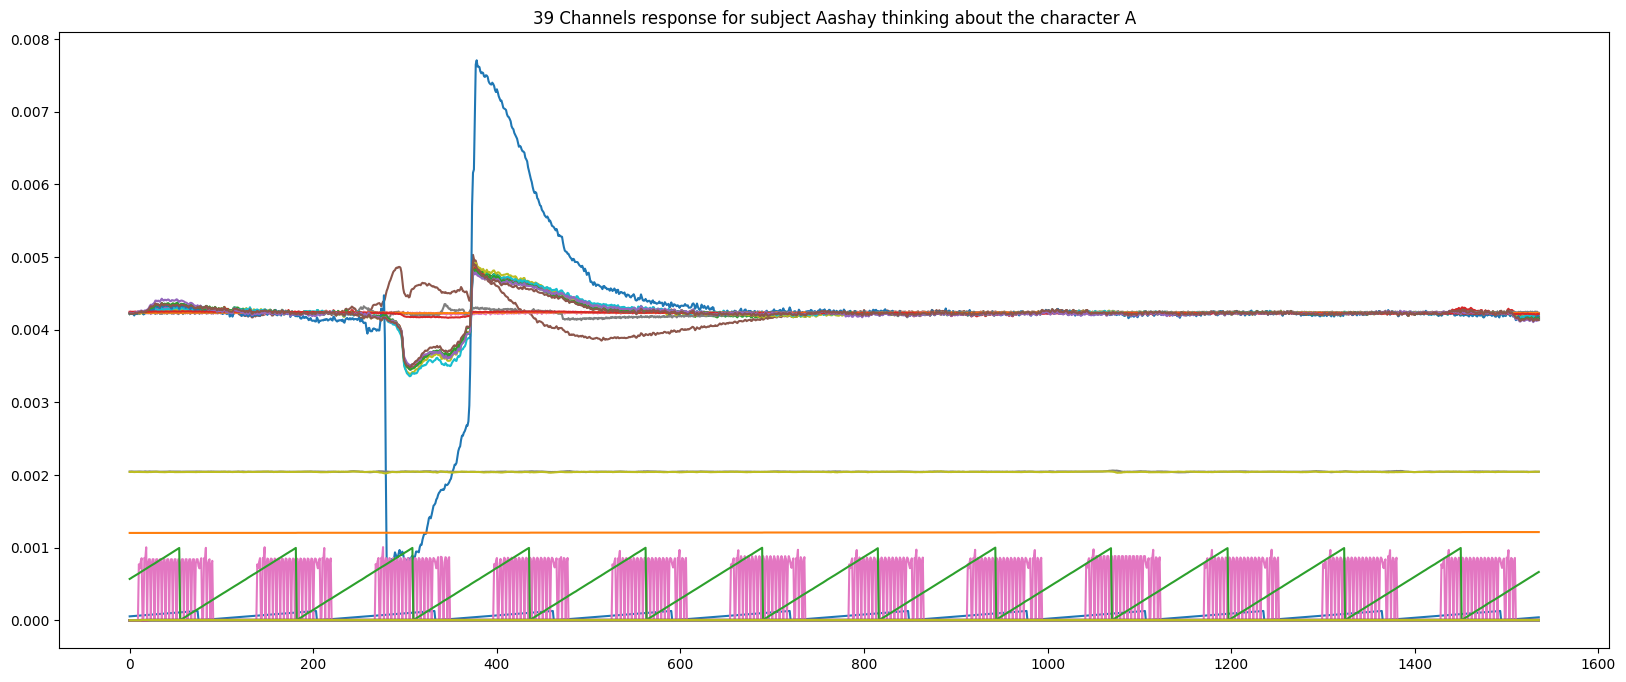

In [12]:
def plot_channels(df, column):
    plt.rcParams["figure.figsize"] = (20,8)
    plt.plot(df[column], label = str(column))
    plt.title(f'39 Channels response for subject Aashay thinking about the character A')

for c in channels:
    plot_channels(df = df_data, column=c)